### **Install Importanr Libraries**

In [ ]:
pip install gensim 

In [ ]:
pip install spacy 

In [ ]:
pip install pyLDAvis 

     |████████████████████████████████| 1.7 MB 4.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=bc418c101265adf34c917a59c0d3fbbefaa182c1eb0749a7e763976f394f09fc
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


## Importing Major Libraries to be used all over program 

In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


## Connecting google Drive 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Downloading and Preparing Stopwords from NLTK library

In [ ]:
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

#adding some new stopwords 
file = open("/content/drive/MyDrive/NLP/extended_stopwords.txt", "r")
stop_words.extend([line.strip() for line in file.readlines()])
file.close()

## Fetching Dataset and convert them into DataFrame

In [ ]:
import pandas as pd 
df = pd.read_csv("/content/drive/MyDrive/NLP/bbc-text.csv")

In [ ]:
df.info()
#we have total 2225 observations in the data
#we have only 2 columns i.e category(Label), text
#we can se there no null data in our dataset so we can move further..

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [ ]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


## Preprocessing of the Data 

In [ ]:
df['text'] = \
df['text'].map(lambda x: x.lower())

In [ ]:
#converting DataFrame into List 
data = df.text.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['tv future in the hands of viewers with home theatre systems plasma '
 'high-definition tvs and digital video recorders moving into the living room '
 'the way people watch tv will be radically different in five years time. that '
 'is according to an expert panel which gathered at the annual consumer '
 'electronics show in las vegas to discuss how these new technologies will '
 'impact one of our favourite pastimes. with the us leading the trend '
 'programmes and other content will be delivered to viewers via home networks '
 'through cable satellite telecoms companies and broadband service providers '
 'to front rooms and portable devices. one of the most talked-about '
 'technologies of ces has been digital and personal video recorders (dvr and '
 'pvr). these set-top boxes like the us s tivo and the uk s sky+ system allow '
 'people to record store play pause and forward wind tv programmes when they '
 'want. essentially the technology allows for much more personalised tv. they 

In [ ]:
#Function to Tokenize the Data
def sent_to_words(sentences, deacc=True):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence),deacc = True))

data_words = list(sent_to_words(data))
print(data_words[:1])

[['tv', 'future', 'in', 'the', 'hands', 'of', 'viewers', 'with', 'home', 'theatre', 'systems', 'plasma', 'high', 'definition', 'tvs', 'and', 'digital', 'video', 'recorders', 'moving', 'into', 'the', 'living', 'room', 'the', 'way', 'people', 'watch', 'tv', 'will', 'be', 'radically', 'different', 'in', 'five', 'years', 'time', 'that', 'is', 'according', 'to', 'an', 'expert', 'panel', 'which', 'gathered', 'at', 'the', 'annual', 'consumer', 'electronics', 'show', 'in', 'las', 'vegas', 'to', 'discuss', 'how', 'these', 'new', 'technologies', 'will', 'impact', 'one', 'of', 'our', 'favourite', 'pastimes', 'with', 'the', 'us', 'leading', 'the', 'trend', 'programmes', 'and', 'other', 'content', 'will', 'be', 'delivered', 'to', 'viewers', 'via', 'home', 'networks', 'through', 'cable', 'satellite', 'telecoms', 'companies', 'and', 'broadband', 'service', 'providers', 'to', 'front', 'rooms', 'and', 'portable', 'devices', 'one', 'of', 'the', 'most', 'talked', 'about', 'technologies', 'of', 'ces', 'ha

In [ ]:
#Definig the Bigram and Trigram Models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['tv', 'future', 'in', 'the', 'hands', 'of', 'viewers', 'with', 'home', 'theatre', 'systems', 'plasma', 'high_definition_tvs', 'and', 'digital_video_recorders', 'moving', 'into', 'the', 'living_room', 'the', 'way', 'people', 'watch', 'tv', 'will', 'be', 'radically', 'different', 'in', 'five', 'years', 'time', 'that', 'is', 'according', 'to', 'an', 'expert', 'panel', 'which', 'gathered', 'at', 'the', 'annual', 'consumer_electronics_show', 'in', 'las_vegas', 'to', 'discuss', 'how', 'these', 'new', 'technologies', 'will', 'impact', 'one', 'of', 'our', 'favourite', 'pastimes', 'with', 'the', 'us', 'leading', 'the', 'trend', 'programmes', 'and', 'other', 'content', 'will', 'be', 'delivered', 'to', 'viewers', 'via', 'home', 'networks', 'through', 'cable', 'satellite', 'telecoms', 'companies', 'and', 'broadband', 'service_providers', 'to', 'front', 'rooms', 'and', 'portable_devices', 'one', 'of', 'the', 'most', 'talked', 'about', 'technologies', 'of', 'ces', 'has', 'been', 'digital', 'and', '

In [ ]:
#creating fuctions for removing stopwords
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

#creating fuctions for making bigram
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

#creating fuctions for making trigram
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

#creating fuctions for Lemmitization
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): #corpus will have the words that belong to only these part of speech
    
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
#Using all the Functions Created for Preprocessing

data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['tv', 'future', 'hand', 'digital', 'move', 'people', 'watch', 'tv', 'radically', 'year', 'time', 'expert', 'panel', 'gather', 'annual', 'discuss', 'technology', 'impact', 'favourite', 'pastime', 'lead', 'trend', 'programme', 'content', 'deliver', 'viewer', 'network', 'cable', 'satellite', 'telecom', 'company', 'broadband', 'front', 'room', 'talk', 'technology', 'digital', 'personal', 'dvr', 'pvr', 'set', 'tivo', 'sky', 'system', 'people', 'record', 'store', 'play', 'pause', 'forward', 'wind', 'tv_programme', 'essentially', 'technology', 'personalise', 'tv', 'build', 'high_definition', 'tv', 'set', 'big', 'business', 'programming', 'people', 'forward', 'wind', 'advert', 'forget', 'abide', 'network', 'channel', 'schedule', 'put', 'network', 'satellite', 'company', 'worry', 'term', 'advertising', 'revenue', 'brand', 'identity', 'viewer', 'loyalty', 'channel', 'lead', 'technology', 'moment', 'concern', 'raise', 'grow', 'sky', 'month', 'year', 'time', 'like', 'issue', 'lose', 'advertising

In [ ]:
# Again Removing Stop Words
# sometimes Lemma can be equivalent to the stopwords... 
data_words_nostops = remove_stopwords(data_lemmatized)

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


In [ ]:
data_words_bigrams

In [ ]:
corpus 

[[(0, 1),
  (1, 1),
  (2, 2),
  (3, 1),
  (4, 1),
  (5, 2),
  (6, 1),
  (7, 6),
  (8, 2),
  (9, 2),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 2),
  (15, 1),
  (16, 1),
  (17, 5),
  (18, 2),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 3),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 4),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 2),
  (32, 1),
  (33, 1),
  (34, 3),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 2),
  (43, 1),
  (44, 1),
  (45, 2),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 2),
  (50, 2),
  (51, 1),
  (52, 2),
  (53, 1),
  (54, 1),
  (55, 2),
  (56, 2),
  (57, 1),
  (58, 2),
  (59, 2),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 2),
  (65, 1),
  (66, 1),
  (67, 3),
  (68, 1),
  (69, 2),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 2),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 2),
  (78, 2),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 4),
  (83, 1),
  (84, 2),
  (85, 1),
  (86, 1),
  (87, 2),
  (88, 1),
  (89, 7),
  (90, 1),
  (91, 1)

In [ ]:
texts

## Using LDA model for Topic Modelling

In [ ]:
#here we are trying to get the optimal model according to the Coherence score(meseaure of Separability) to figure out no of topics ..
def tune_model(dictionary, corpus, texts, limit, start, step):
    
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True,
                                           )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(round(coherencemodel.get_coherence(),3))

    return model_list, coherence_values

In [ ]:
# Can take a long time to run
from tqdm import tqdm
model_list, coherence_values = tune_model(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=10, step=1)

100%|██████████| 8/8 [02:06<00:00, 15.77s/it]


### Plotting Line Graph for the coherence score according to the number of topics

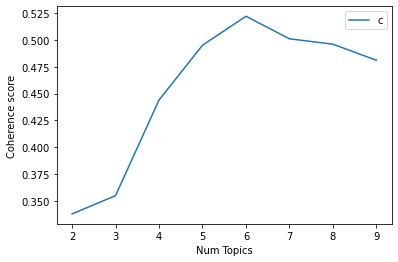

In [ ]:
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.338
Num Topics = 3  has Coherence Value of 0.355
Num Topics = 4  has Coherence Value of 0.444
Num Topics = 5  has Coherence Value of 0.495
Num Topics = 6  has Coherence Value of 0.522
Num Topics = 7  has Coherence Value of 0.501
Num Topics = 8  has Coherence Value of 0.496
Num Topics = 9  has Coherence Value of 0.481


In [ ]:
#here we knew that the coherence score is maximum for 6 topics so that will become our optimal model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


In [ ]:
#getting dominant words for each topics 
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.020*"year" + 0.014*"rise" + 0.013*"sale" + 0.011*"company" + 0.011*"firm" '
  '+ 0.009*"expect" + 0.008*"report" + 0.008*"share" + 0.007*"figure" + '
  '0.007*"fall"'),
 (1,
  '0.015*"government" + 0.014*"people" + 0.010*"plan" + 0.008*"party" + '
  '0.008*"issue" + 0.008*"labour" + 0.008*"election" + 0.007*"tell" + '
  '0.007*"public" + 0.006*"claim"'),
 (2,
  '0.023*"film" + 0.017*"year" + 0.012*"include" + 0.011*"music" + '
  '0.010*"award" + 0.010*"star" + 0.009*"top" + 0.009*"number" + 0.008*"woman" '
  '+ 0.007*"director"'),
 (3,
  '0.019*"people" + 0.013*"technology" + 0.011*"game" + 0.010*"mobile" + '
  '0.009*"phone" + 0.009*"music" + 0.008*"service" + 0.008*"tv" + '
  '0.008*"network" + 0.006*"work"'),
 (4,
  '0.015*"time" + 0.014*"play" + 0.013*"year" + 0.012*"player" + 0.012*"win" + '
  '0.012*"game" + 0.008*"good" + 0.008*"team" + 0.008*"set" + 0.007*"match"'),
 (5,
  '0.014*"attack" + 0.014*"site" + 0.013*"people" + 0.012*"software" + '
  '0.012*"information" + 

In [ ]:
#lets compare with the labels present in the data
df.category.unique()

array(['tech', 'business', 'sport', 'entertainment', 'politics'],
      dtype=object)

# Result:-
we have only 5 topics in our original data but our model is detecting addtional topic so if we compare:

topic 0 tells us about = Business

topic 1 tells us about = Politics

topic 2 tells us about = Entertainment

topic 3 tells us about = Tech

topic 4 tells us about = Sports

topic 5 tells us about = Tech( advance tech)

here we can see that topic 3 and 5 have similar background of Tech but the Topic words gives different context. topic 3 talk about tech devices and thier application. whereas the topic 5 gives information about the hacking of software and their information...


## Lets cluster those topics and see the dominants words in graphical format

In [ ]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.020886 -0.087371       1        1  20.820579
0     -0.027197 -0.253586       2        1  20.123357
4     -0.163696  0.067226       3        1  19.627865
3      0.066345 -0.040206       4        1  16.180574
2     -0.176558  0.173763       5        1  13.095216
5      0.280221  0.140174       6        1  10.152408, topic_info=        Term         Freq        Total Category  logprob  loglift
321     film   839.000000   839.000000  Default  30.0000  30.0000
89    people  1956.000000  1956.000000  Default  29.0000  29.0000
612     rise   739.000000   739.000000  Default  28.0000  28.0000
275     game  1075.000000  1075.000000  Default  27.0000  27.0000
141     year  2524.000000  2524.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
956     base   125.919687   452.991120   Topic6  -5.3456   1.0072
88        pc   108.582055   277.481105   Topic6  -5.4938   1.3492
287   number   111.735630   834.450118   Topic6  -5.4651   0.2768
1023    send   102.863551   191.029290   Topic6  -5.5479   1.6684
139     work   103.959716   932.801954   Topic6  -5.5373   0.0933

[380 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1002      1  0.085770  access
1002      2  0.008577  access
1002      4  0.724757  access
1002      6  0.180117  access
146       1  0.898975  accuse
...     ...       ...     ...
141       1  0.010693    year
141       2  0.415058    year
141       3  0.255451    year
141       4  0.089507    year
141       5  0.229707    year

[654 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 5, 4, 3, 6])

In [ ]:
#visualization libraries 
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

In [ ]:
#Creating Word Cloud
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

In [ ]:
#preparation for wordcloud
topics = lda_model.show_topics(formatted=False)
topic_words = dict(topics)

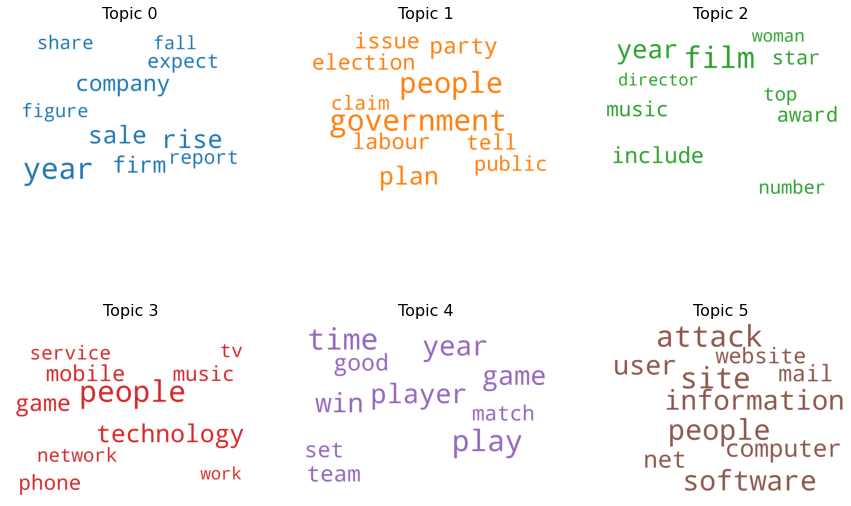

In [ ]:
fig, axes = plt.subplots(2,3 , figsize=(15,10), sharex=True, sharey=True)
#fig.delaxes(ax[1,1])

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

# Conclusion :- 

I have successfully implemented the LDA model for Topic Modelling. It has classify 6 topics in our dataset with the coherence score of 0.52 , whereas our dataset only has 5 Labels, so here we also manage to get the hidden topic which was related towards hacking. 